
    Target :
        Inreased LR to reach to target quickly.
        Added data augmentation ColorJitter and RandomInitialization
    Results:
        Parameters: 9,752
        Best Train Accuracy: 98.4 (17th Epoch)
        Best Train Accuracy: 99.44 (14th Epoch)
    Analysis:
        Inreasing LR works to achieve target acc. 
        Data augmentation helps model to see variety of test data
        


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
# Experiment-1 Reducing Parameters (set the model right). Impact: Parameters gone down/ no overfit/ low accuracy
# Experiment-2 Re-Structuring model looking at the receptive field. Impact: Parameters gone down further/ no overfit/ low accuracy
# Experiment-3 Adding BatchNorm to bump up the accuracy . Impact: limited parameters/ Overfitting/ accuracy improved
# Experiment-4 Adding Dropout to regularize. Impact: limited parameters/ no overfit/ test accuracy consistent
# Experiment-5 Restructuring model with GAP at the end of the convolutions. limited parameters/ underfit / no target acc
# Experiment-6 Reducing Dropout value to 10% as in experiment-5 it was highly penalized. Adding many transforms
# Experiment-7 Playing with LR Scheduler
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(dropout_value)
        ) #input:28x28 Output:26x26 RF:3x3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:26x26 Output:24x24 RF:5x5

          ######################### TRANSITION BLOCK 1 ############################
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24 Output:12x12 RF:6x6

        self.conv_1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            
        ) #input:13x13 Output:12x12 RF:6x6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:12x12 Output:10x10 RF:10x10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:14x14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:18x18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value)
        ) #input:8x8 Output:6x6 RF:22x22

         ######################### TRANSITION BLOCK 2 ############################
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6 Output:1x1 RF:32x32

        self.conv_1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.conv_1x1_1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.conv_1x1_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
                            
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
# 0.0015 Best Test Acc - 99.09
# 0.003 Best Test Acc - 98.94
# 0.0001 Best Test Acc - 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0001)
lrscheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16893453896045685 Batch_id=468 Accuracy=87.64: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.11663097143173218 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.02564043365418911 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:24<00:00, 19.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.05042487010359764 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:24<00:00, 19.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.07795511186122894 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.06270474940538406 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.08018746227025986 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:25<00:00, 18.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.023715153336524963 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:24<00:00, 26.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.1592056304216385 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.06114104390144348 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.0433235764503479 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:24<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.08906915783882141 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:23<00:00, 19.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.028513869270682335 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.055414121598005295 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.02527116797864437 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.06306334584951401 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.037232283502817154 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.08511900901794434 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.045159563422203064 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:24<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.025509364902973175 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.06249287351965904 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:24<00:00, 19.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.04468737542629242 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.10520132631063461 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.04940764978528023 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.020434105768799782 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:24<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.05134208872914314 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.0777968019247055 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 27


Loss=0.024042898789048195 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.019406691193580627 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 29


Loss=0.026801863685250282 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.030970564112067223 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:24<00:00, 18.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.07715737074613571 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.03449692204594612 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.07427062839269638 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:24<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 34


Loss=0.0682612881064415 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.06337135285139084 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 36


Loss=0.010760371573269367 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.031370650976896286 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 38


Loss=0.018819114193320274 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.03741136193275452 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]



Test set: Average loss: 0.0185, Accuracy: 9948/10000 (99.48%)





```
 Plotting train and test losses vs accuracies
```



Text(0.5, 1.0, 'Test Accuracy')

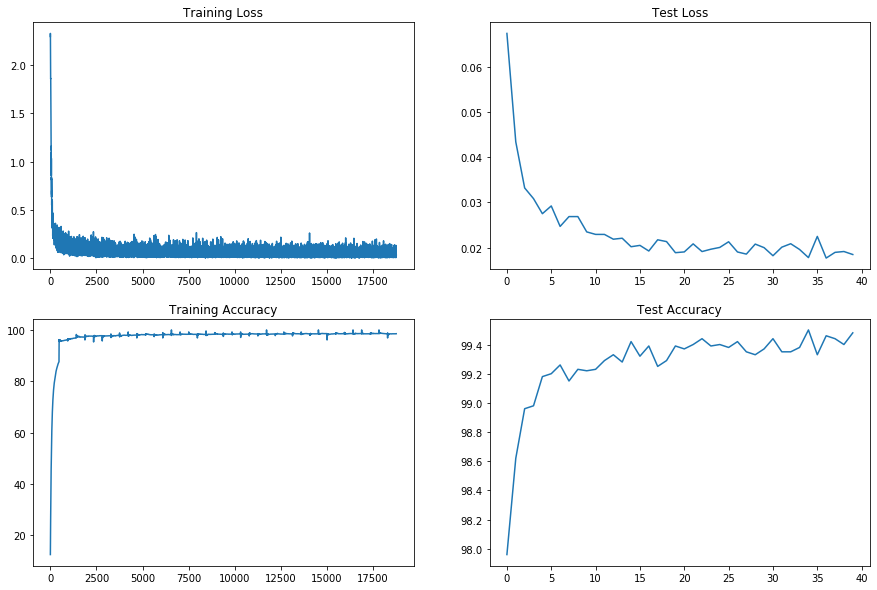

In [9]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")